This notebook does fine-tuning of facenet over the celeb-A dataset. The facenet model available publicly has been trained over the VGGFace2 model and the CASIA-webface model. Since our diffusion models have been trained on celeb-A dataset, we finetuned the model over celeb-A dataset. Since we ran this code as a script on GCP, there are no inline outputs. 

In [ ]:
!pip install --upgrade torch torchvision torchaudio natsort
!pip install --upgrade gdown
!pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████████████▎             | 509.1 MB 1.2 MB/s eta 0:05:15

In [ ]:
import random
import torch
import torchvision
from torchvision import transforms, datasets
import os
import zipfile
import gdown
from torch.utils.data import Dataset
from natsort import natsorted
from PIL import Image
import glob
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torch.nn as nn
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
import gc

In [ ]:
manual_seed = 999
random.seed(manual_seed)
torch.manual_seed(manual_seed)

In [ ]:
ngpu = 1
device = torch.device('cuda:0' if (
    torch.cuda.is_available() and ngpu > 0) else 'cpu')

device

device(type='cuda', index=0)

In [ ]:
data_root = '/content/data/celeba'
download_path = f'{data_root}/CelebA.zip'
img_folder = '/content/data/celeba/abc'
url = 'https://drive.google.com/uc?id=1pUv-X_r738skkbJgoytwJ7bQLxVmGeye'

if not os.path.exists(data_root):
  os.makedirs(data_root)

gdown.download(url, download_path, quiet=False)

In [ ]:
with zipfile.ZipFile(download_path, 'r') as ziphandler:
  ziphandler.extractall(img_folder)

In [ ]:
class CelebADataset(Dataset):


  def __init__(self, root_dir, transform=None):
    image_names = os.listdir(root_dir)
    self.root_dir = root_dir
    self.transform = transform 
    self.image_names = natsorted(glob.glob(root_dir + '/*/*.jpg'))


  def __len__(self): 
    return len(self.image_names)


  def __getitem__(self, idx):
    img_path = self.image_names[idx]
    img = Image.open(img_path).convert('RGB')
    if self.transform:
      img = self.transform(img)

    return (img, int(img_path.split('/')[-2]) - 1)

In [ ]:
image_size = 160

transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    fixed_image_standardization
    # transforms.Normalize(mean=[0.5, 0.5, 0.5],
                        #   std=[0.5, 0.5, 0.5])
])

celeba_dataset_train = CelebADataset(f'{img_folder}/0', transform)
celeba_dataset_val = CelebADataset(f'{img_folder}/1', transform)
celeba_dataset_test = CelebADataset(f'{img_folder}/2', transform)

In [ ]:
batch_size = 32
num_workers = 0 if device.type == 'cuda' else 2
# pin_memory = True if device.type == 'cuda' else False
pin_memory = False

In [ ]:
train_dataloader = torch.utils.data.DataLoader(celeba_dataset_train,
                                                      batch_size=batch_size,
                                                      num_workers=num_workers,
                                                      pin_memory=pin_memory,
                                                      shuffle=True)
val_dataloader = torch.utils.data.DataLoader(celeba_dataset_train,
                                                      batch_size=batch_size,
                                                      num_workers=num_workers,
                                                      pin_memory=pin_memory,
                                                      shuffle=True)
test_dataloader = torch.utils.data.DataLoader(celeba_dataset_train,
                                                      batch_size=batch_size,
                                                      num_workers=num_workers,
                                                      pin_memory=pin_memory,
                                                      shuffle=True)

### Plot some training images

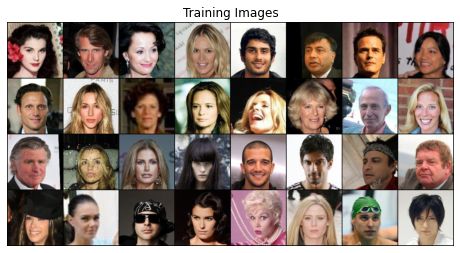

In [ ]:
real_batch = next(iter(train_dataloader))
image_grid = vutils.make_grid(real_batch[0].to(device)[:64],
                              padding=2,
                              normalize=True).cpu()
image_grid = np.transpose(image_grid, (1, 2, 0))

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(image_grid)

## Model Implementation

### Weight Initialization

### Training

In [ ]:
model = InceptionResnetV1(pretrained='vggface2')

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:
model

In [ ]:
model.last_bn = nn.Identity()
model.logits = nn.Identity()

In [ ]:
for name, param in model.named_parameters():
    param.requires_grad = False

In [ ]:
model_new_resnet = nn.Sequential(
    model,
    nn.ReLU(),
    nn.Linear(512, 10177)
).to(device)

In [ ]:
epochs = 8
workers = 0 if os.name == 'nt' else 8

In [ ]:
optimizer = optim.Adam(model_new_resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

In [ ]:
torch.backends.cudnn.enabled = False

In [ ]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

# print('\n\nInitial')
# print('-' * 10)
# model_new_resnet.eval()
# training.pass_epoch(
#     model_new_resnet, loss_fn, model_new_resnet,
#     batch_metrics=metrics, show_running=True, device=device,
#     writer=writer
# )

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    model_new_resnet.train()
    training.pass_epoch(
        model_new_resnet, loss_fn, train_dataloader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    model_new_resnet.eval()
    training.pass_epoch(
        model_new_resnet, loss_fn, val_dataloader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()


Epoch 1/8
----------
Train |   695/5087 | loss:    9.0334 | fps:  194.9022 | acc:    0.0062   

RuntimeError: ignored

In [ ]:
for i_batch, (x, y) in enumerate(train_dataloader):
    print(i_batch)
    print(x.shape)
    print(y.shape)
    break

0
torch.Size([128, 3, 160, 160])
torch.Size([128])


In [ ]:
# del model
# del model_new_resnet
gc.collect()
torch.cuda.empty_cache()

RuntimeError: ignored

In [ ]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
